Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. Необходимо построить модель предсказания рыночной цены автомобиля на основе исторических данных: технические характеристики, комплектации и цены автомобилей.  

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

## 1.1. Знакомство с данными

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


## 1.1. Выводы после ознакомления:
- Всего предоставлено 354369 объектов
- После зачитывания столбцы имеют тип либо int64, либо object. Три столбца object - это данные дата/время, без пропусков. Все остальные столбцы object - это категориальные данные и все они имеют пропуски, за исключением столбца Brand. Библиотека LightGBM самостоятельно обрабатывает пропуски в категориальных данных, но требует положительный целочисленный тип данных в категориальных столбцах. Поэтому мы преобразуем все эти столбцы в тип category с сохранением пропусков. Для обучения других моделей мы для пропусков создадим отдельную категории unknown
- Целочисленные данные не имеют пропусков, но некоторые столбцы имеют явные ошибочные данные - годы регистрации, равные 1000 или 9999, мощности, равные 0 или 20000. Разберемся с этим на следующем этапе.
- Столбцы PostalCode и NumberOfPictures, в котором всюду 0, не понадобятся для обучения моделей. Скорее всего, также не понадобятся некоторые или все столбцы дата/время, но решение об этом будет принято после более детального знакомства с данными в этих столбцах.

## 1.2. Преобразование типов, обработка ошибочных данных.

In [7]:
# создадим список столбцов, которые не будут использоваться при обучении моделей
columns_to_drop = ['PostalCode', 'NumberOfPictures']

# создадим список категориальных столбцов
columns_category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# создадим список столбцов дата/время
columns_dates = ['DateCrawled', 'DateCreated', 'LastSeen']

In [8]:
for col in columns_dates:
    data[col] = pd.to_datetime(data[col])
    print(col, data[col].min(), data[col].max())

DateCrawled 2016-03-05 14:06:22 2016-04-07 14:36:58
DateCreated 2014-03-10 00:00:00 2016-04-07 00:00:00
LastSeen 2016-03-05 14:15:08 2016-04-07 14:58:51


- Все объекты были получены из базы в течение примерно одного месяца 2016 года (с 5 марта по 7 апреля). При этом последняя активность каждого пользователя фиксировалась в этот же период времени. Это означает, что все объекты актуальны на момент выгрузки их из базы. Это также означает, что для построения наших моделей столбцы DateCrawled и LastSeen не нужны. 
- Даты создания анкет лежат в более широком диапазоне. Возможно, в этом столбце сохранен важный признак - срок экспозиции. Создадим новый столбец DaysExposed и посмотрим распределение данных в нем.

In [9]:
data['DaysExposed'] = (data['DateCrawled'] - data['DateCreated']).dt.days

In [10]:
data['DaysExposed'].describe()

count    354369.000000
mean          0.086698
std           2.135045
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         737.000000
Name: DaysExposed, dtype: float64

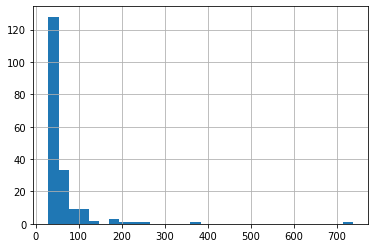

In [11]:
# судя по статистикам, подавляющая часть данных - это анкеты созданные в день выгрузки, 
# посмотрим анкеты, в которых срок между датой создания и датой выгрузки превышает 30 дней
ax = data['DaysExposed'].hist(bins=30, range=(30, 737))

In [12]:
len(data[data['DaysExposed'] > 30])

182

- Данных, в которых срок между датой создания и датой выгрузки превышает 30 дней, немного - всего 182 объекта. При этом нет достаточных оснований считать эти данные неактуальными, поскольку ранее при сравнении столбцов DateCrawled и LastSeen мы убедились, что все данные актуальны.
- Тем не менее, учитывая, что таких данных совсем немного и по параметру DaysExposed эти данные очень сильно отличаются от всех остальных, принято решение избавиться от них.
- Был проведен анализ всех столбцов типа дата/время. С учетом удаления данных, в которых срок между датой создания и датой выгрузки превышает 30 дней, принято решение не использовать все столбцы дата/время для обучения моделей.

In [13]:
days_exposed_to_be_dropped = 30
filter = data['DaysExposed'] <= days_exposed_to_be_dropped
data = data[filter]

In [14]:
columns_to_drop += columns_dates
columns_to_drop.append('DaysExposed')

In [15]:
# для визуального изучения потенциальных ошибок в некоторых целочисленных столбцах создадим соотв. функцию
def show_outlier(col, min=None, max=None):
    if min is not None:
        data[(data[col] < min)][col].hist(bins=50)
        plt.show()
    if max is not None:
        data[(data[col] > max)][col].hist(bins=50)
        plt.show()

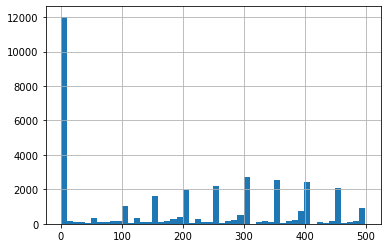

In [16]:
show_outlier('Price', min=500)

In [17]:
# вызывают большое сомнение данные около 0, рассмотрим их
data[(data['Price'] < 10)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysExposed
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58,0
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34,0
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38,0
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54,0
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08,0
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23,0
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24,0
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32,0


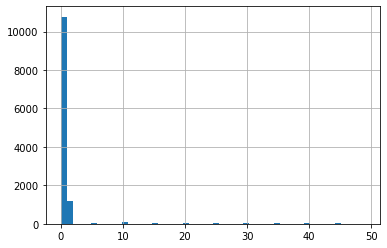

In [18]:
show_outlier('Price', min=50)

Объекты с 0 (и близко к этому) ценой - явно ошибочные, возможно, владельцы сознательно не хотели указывать цену и использовали 0 как способ это сделать. Удалим такие объекты, как не не имеющие целевого признака

In [19]:
price_min_to_be_dropped = 50
filter = data['Price'] > price_min_to_be_dropped
data = data[filter]

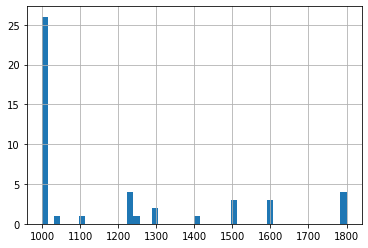

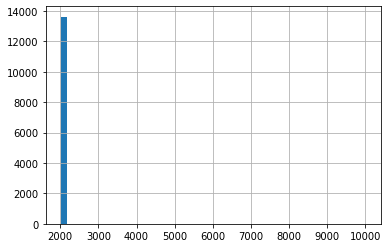

In [20]:
show_outlier('RegistrationYear', min=1900, max=2016)

In [21]:
# объектов с годом регистрации ранее 1900 явно ошибки и их немного 
# объектов с годом регистрации более 2016 года (хотя год выгрузки =2016) достаточно много ~14000
# и почти все они имеют не явно ошибочные значения, посмотрим на них более внимательно
data[data['RegistrationYear'] > 2016].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,DaysExposed
count,13692.000000,13692.000000,13692.000000,13692.000000,13692.000000,13692.0,13692.00000,13692.000000
mean,3342.154324,2040.714870,88.532720,132119.485831,4.817558,0.0,48513.83976,0.052585
std,3470.397813,366.003519,248.693865,36294.213360,3.993295,0.0,25090.76408,0.554669
min,55.000000,2017.000000,0.000000,5000.000000,0.000000,0.0,1067.00000,0.000000
25%,1099.000000,2017.000000,0.000000,125000.000000,1.000000,0.0,28219.00000,0.000000
50%,2000.000000,2017.000000,80.000000,150000.000000,4.000000,0.0,46519.00000,0.000000
75%,4290.000000,2018.000000,116.000000,150000.000000,8.000000,0.0,66464.75000,0.000000
max,20000.000000,9999.000000,16011.000000,150000.000000,12.000000,0.0,99994.00000,25.000000


Преобладающее кол-во таких объектов имеет год регистрации 2017 или 2018 при том, что анкета и создана, и выгружена из базы в 2016 году. Кроме того, более 75% таких объектов имеют пробег от 125000 и выше, что свидетельствует о том, что автомобиль имеет приличный возраст. Будем считать, что такие объекты, как и объекты с годом регистрации ранее 1900 года, на самом деле имеют пропуск в столбцах RegistrationYear и RegistrationMonth.

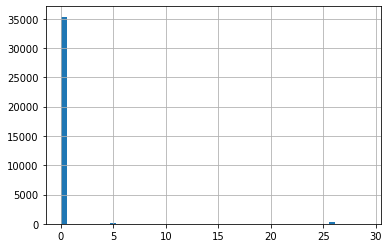

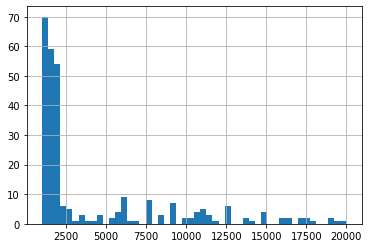

In [22]:
show_outlier('Power', min=30, max=1000)

In [23]:
data[(data['Power'] > 1) & (data['Power'] < 30)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysExposed
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08,0
1235,2016-03-08 20:43:16,4450,small,1971,manual,23,500,70000,5,petrol,fiat,no,2016-03-08,0,33729,2016-04-05 18:44:51,0
1331,2016-04-03 19:53:44,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,NaN,2016-04-03,0,9337,2016-04-05 20:45:24,0
3349,2016-03-29 17:37:58,1990,small,2004,NaN,7,polo,150000,5,gasoline,volkswagen,no,2016-03-29,0,37124,2016-04-02 05:16:40,0
3419,2016-03-27 13:46:49,2300,NaN,2017,manual,26,601,70000,1,NaN,trabant,no,2016-03-27,0,39443,2016-04-07 09:45:27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11,0,16515,2016-04-05 19:47:27,1
353127,2016-03-26 18:53:12,8600,convertible,2012,manual,8,NaN,5000,3,gasoline,sonstige_autos,no,2016-03-26,0,82399,2016-04-06 08:17:29,0
353447,2016-03-27 00:46:19,2900,small,1969,manual,18,500,5000,8,petrol,fiat,no,2016-03-26,0,74076,2016-03-28 17:45:04,1
353501,2016-03-27 13:49:55,11300,sedan,1988,manual,29,other,150000,3,petrol,citroen,no,2016-03-27,0,18347,2016-04-07 09:46:17,0


In [24]:
data[(data['Power'] > 1000) & (data['Power'] < 1500)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysExposed
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26,0
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36,0
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26,0
19826,2016-03-18 23:52:30,3390,sedan,2009,manual,1240,micra,60000,3,petrol,nissan,no,2016-03-18,0,22083,2016-03-31 11:16:49,0
21609,2016-03-29 17:53:17,200,small,2000,manual,1200,NaN,125000,4,petrol,lancia,NaN,2016-03-29,0,10585,2016-04-06 03:45:24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345756,2016-03-30 17:56:27,850,NaN,2005,manual,1003,ka,5000,12,petrol,ford,no,2016-03-30,0,45891,2016-04-05 06:17:55,0
347016,2016-03-21 20:58:26,450,sedan,1996,auto,1004,vectra,80000,5,petrol,opel,yes,2016-03-21,0,12689,2016-03-21 20:58:26,0
348968,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04,0,28259,2016-04-04 18:53:25,0
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07,0,66117,2016-03-09 12:47:08,0


- Подавляющее число объектов с подозрительно низкой мощностью (<30 л.с.) имеет указанную в анкете мощность = 0. Их в нашей выборке достаточно много ~40000.
- Объектов с подозрительно высокой мощностью не так много, судя по всему, это явные ошибки (вместо л.с. указывается объем двигателя).
- Будем считать, что объекты, в которых указанная мощность менее 30 или более 1000 л.с., имеют на самом деле пропуск в столбце Power. 
- Заполним все выявленные ошибочные значения в столбцах RegistrationYear, Power и RegistrationMonth np.nan

In [25]:
def outlier_to_nan(col, min=None, max=None):
    if min is not None:
        data.loc[data[col] < min, col] = np.nan
    if max is not None:
        data.loc[data[col] > max, col] = np.nan

In [26]:
# зададим диапазоны года регистрации и мощности, выход за который мы считаем  ошибкой
min_registration_year = 1900
max_registration_year = 2016
min_power = 30
max_power = 1000

In [27]:
# исправим ошибки на nan
outlier_to_nan('RegistrationYear', min=min_registration_year, max=max_registration_year)
outlier_to_nan('Power', min=min_power, max=max_power)
data.loc[data['RegistrationYear'].isna(), 'RegistrationMonth'] = np.nan
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = np.nan

In [28]:
# избавимся от столбцов, которые не будут использоваться при обучении моделей
data = data.drop(columns=columns_to_drop)

In [29]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,341438.000000,327700.000000,304962.000000,341438.000000,299193.000000
mean,4580.235867,2002.617620,120.654324,128480.134021,6.391908
std,4514.292043,6.869516,54.557570,37285.280358,3.349304
min,55.000000,1910.000000,30.000000,5000.000000,1.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,4.000000
50%,2900.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6500.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,1000.000000,150000.000000,12.000000


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341438 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              341438 non-null  int64  
 1   VehicleType        308614 non-null  object 
 2   RegistrationYear   327700 non-null  float64
 3   Gearbox            324901 non-null  object 
 4   Power              304962 non-null  float64
 5   Model              324338 non-null  object 
 6   Kilometer          341438 non-null  int64  
 7   RegistrationMonth  299193 non-null  float64
 8   FuelType           312876 non-null  object 
 9   Brand              341438 non-null  object 
 10  NotRepaired        276781 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 31.3+ MB


In [31]:
# пакет LightGBM имеет свои средства для работы с категориями и пропусками,
# поэтому далее подготовку данных для разных моделей будем осуществлять в разных df
data_lgbm = data.copy()
data_other = data.copy()

In [32]:
# для исследования работы пакета LightGBM мы создадим еще один сет для обучения его моделей
# в нем будут сохранены пропуски в категориальных данных, но будут удалены все объекты с неявными пропусками в числовых данных
data_lgbm_dropfault = data_lgbm.dropna(subset=['Power', 'RegistrationYear', 'RegistrationMonth']).copy()
data_lgbm_dropfault.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277122 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              277122 non-null  int64  
 1   VehicleType        269647 non-null  object 
 2   RegistrationYear   277122 non-null  float64
 3   Gearbox            273402 non-null  object 
 4   Power              277122 non-null  float64
 5   Model              268379 non-null  object 
 6   Kilometer          277122 non-null  int64  
 7   RegistrationMonth  277122 non-null  float64
 8   FuelType           266115 non-null  object 
 9   Brand              277122 non-null  object 
 10  NotRepaired        243327 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 25.4+ MB


In [33]:
# категориальные признаки преобразуем в category для сетов lgbm, 
# для других сетов заполним пропуски новой категорией unknown
data_other[columns_category] = data_other[columns_category].fillna('unknown')
data_lgbm[columns_category] = data_lgbm[columns_category].astype('category')
data_lgbm_dropfault[columns_category] = data_lgbm_dropfault[columns_category].astype('category')

In [34]:
# подготовка данных для LightGBM завершена
X_lgbm = data_lgbm.drop(columns='Price')
y_lgbm = data_lgbm['Price']

X_lgbm_dropfault = data_lgbm_dropfault.drop(columns='Price')
y_lgbm_dropfault = data_lgbm_dropfault['Price']

print('Количество объектов для обучения LightGBM, категории=category, ошибки и пропуски NaN', len(X_lgbm))
print('Количество объектов для обучения LightGBM, категории=category, ошибки удалены       ', len(X_lgbm_dropfault))

Количество объектов для обучения LightGBM, категории=category, ошибки и пропуски NaN 341438
Количество объектов для обучения LightGBM, категории=category, ошибки удалены        277122


In [35]:
# преобразуем категориальные данные для обучения других моделей
data_other = pd.get_dummies(data_other, columns=columns_category, drop_first=True)

У нас остались пропуски (изначально ошибки) в числовых признаках. Их можно заполнить, либо удалить объекты, содержащие пропуски. Поскольку число пропусков относительно размера набора данных небольшое, можно использовать любой метод. Интересно посмотреть, как повлияет на качество моделей метод работы с пропусками. Создадим два отдельных набора для обучения моделей - с заполненными пропусками и с удаленными пропусками

In [36]:
data_other

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993.0,NaN,150000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011.0,190.0,125000,5.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004.0,163.0,125000,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001.0,75.0,150000,6.0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008.0,69.0,90000,7.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,2000.0,NaN,150000,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354365,2200,2005.0,NaN,20000,1.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
354366,1199,2000.0,101.0,125000,3.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996.0,102.0,150000,3.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
data_dropfault = data_other.dropna().copy()
data_imputed = data_other.copy()

In [38]:
# подготовка данных для других моделей, в которых удалены все ошибки в числовых признаках, завершена
X_dropfault = data_dropfault.drop(columns='Price')
y_dropfault = data_dropfault['Price']

# в данных для других моделей, в которых мы будем заполнять пропуски, еще надо будет заполнить пропуски, 
# но мы это сможем сделать только после разбиения данных на обучающую и тестовые выборки
X_imputed = data_imputed.drop(columns='Price')
y_imputed = data_imputed['Price']

print('Количество объектов для обучения Random Forest, категории ohe, ошибки удалены ', len(X_dropfault))
print('Количество объектов для обучения Random Forest, категории ohe, ошибки заменены', len(X_imputed))

Количество объектов для обучения Random Forest, категории ohe, ошибки удалены  277122
Количество объектов для обучения Random Forest, категории ohe, ошибки заменены 341438


# 1. Вывод.
- Всего предоставлено 354369 объектов
- В числовых признаках, включая целевой, явных пропусков нет. Однако были обнаружены явно ошибочные данные, которые расценены как скрытые пропуски. 
- Все объекты с неявными пропусками в целевом признаке (цена близка к 0) - их почти 13000 - были удалены. Кроме того, было удалено менее 200 объектов с необычным рассогласованием дат. Найденные неявные пропуски в других числовых столбцах (мощность, год и месяц регистрации) были явно обозначены как NaN.
- После изучения столбцов с датами (дата выгрузки анкеты из базы, дата последней активности, дата создания анкеты) было принято решение, что эти признаки не могут влиять на цену и они были удалены. Кроме того, на этом же основании были удалены признаки NumberOfPictures и PostalCode.
- Было создано четыре сета данных для обучения моделей:
   - Два для обучения моделей LightGBM. Все категориальные признаки в обоих преобразованы в тип category c сохранением пропусков. В одном наборе сохранены неявные пропуски (ошибки) в числовых признаках, количество объектов в нем 341438. В другом наборе такие пропуски удалены (277122 объектов)
   - Два для обучения моделей RandomForest. Все категориальные признаки в обоих были заполнены unknown и затем применено кодирование ohe. В одном наборе неявные пропуски (ошибки) в числовых признаках заменены на среднее из обучающего набора, количество объектов в нем 341438. В другом наборе такие пропуски удалены (277122 объектов)

# 2. Обучение моделей

In [39]:
RANDOM_STATE = 134
# будем разбивать начальный набор на train, valid, test
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [40]:
# для сохранения результатов исследования различных моделей создадим df
all_results = pd.DataFrame()

In [41]:
def show_results():
    all_results['Assess of overfit'] = ((all_results['RMSE on test'] - all_results['RMSE on train']) / all_results['RMSE on train']).round(2)
    display(all_results.sort_values(by='RMSE on test'))

In [42]:
def add_RMSE_results(row_name, y_train, y_train_predict, y_valid, y_valid_predict, y_test, y_test_predict):
    all_results.loc[row_name, 'RMSE on train'] = round(mean_squared_error(y_train, y_train_predict) ** 0.5, 2)
    all_results.loc[row_name, 'RMSE on valid'] = round(mean_squared_error(y_valid, y_valid_predict) ** 0.5, 2)
    all_results.loc[row_name, 'RMSE on test'] = round(mean_squared_error(y_test, y_test_predict) ** 0.5, 2)

### 2.1. LightGBM

In [45]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_lgbm, y_lgbm)

In [46]:
# добавим результат для dummy модели
mean_value = y_train.mean()
y_train_predict = pd.Series(mean_value, index=y_train.index)
y_valid_predict = pd.Series(mean_value, index=y_valid.index)
y_test_predict = pd.Series(mean_value, index=y_test.index)
add_RMSE_results('Dummy, single value, mean of y_train', y_train, y_train_predict, y_valid, y_valid_predict, y_test, y_test_predict)

In [47]:
# мы преобразовали категориальные данные к типу category, поэтому нет нужды указывать параметр categorical_feature=columns_category
def fit_lgbm_regressor(num_leaves, learning_rate, n_estimators, max_bin):
    model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, max_bin=max_bin, random_state=RANDOM_STATE)
    model.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            eval_metric='l2', 
            early_stopping_rounds=5,
            verbose=0)
    return model

In [48]:
def try_lgbm_and_store_results(note_to_name='', num_leaves=31, learning_rate=0.1, n_estimators=100, max_bin=255):
    start_time = time.time()
    model_gbm = fit_lgbm_regressor(num_leaves, learning_rate, n_estimators, max_bin)
    end_time = time.time()
    best_iter = model_gbm.best_iteration_
    row_name = f'Model LightGBM {note_to_name}, leaves={num_leaves}, learning_rate={learning_rate}, max_bin={max_bin}, best_iteration={best_iter}'
    all_results.loc[row_name, 'learning time'] = round(end_time - start_time, 2)
    y_train_predict = model_gbm.predict(X_train, num_iteration=best_iter)
    y_valid_predict = model_gbm.predict(X_valid, num_iteration=best_iter)
    start_time = time.time()
    y_test_predict = model_gbm.predict(X_test, num_iteration=best_iter)
    end_time = time.time()
    all_results.loc[row_name, 'predict time per 1000 object'] = round((end_time - start_time) * 1000 / len(y_test_predict), 3)
    add_RMSE_results(row_name, y_train, y_train_predict, y_valid, y_valid_predict, y_test, y_test_predict)

In [49]:
%%time
for num_leaves in [31, 70]:
    for learning_rate in [0.1, 0.05]:
        for max_bin in [255, 2500]:
            try_lgbm_and_store_results(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=5000, max_bin=max_bin)

CPU times: user 8min 9s, sys: 5.66 s, total: 8min 15s
Wall time: 2min 12s


In [50]:
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=255, best_iteration=431",1531.74,1633.57,1634.90,5.15,0.020,0.07
"Dummy, single value, mean of y_train",4511.53,4522.83,4514.00,NaN,NaN,0.00


- В таблице модели ранжируются по RMSE на тестовой выборке. Все первые 6 моделей имеют очень близкие показатели точности - RMSE от 1569 до 1586 (разница около 1%). 
- По скорости обучения и предсказания эти 6 моделей делятся на две группы, по 3 модели в каждой. Скорость и обучения и предсказания отличаются в группах примерно в 2 раза. 
- По показателю возможной переобученности модели (относительная разность RMSE на обучающей и тестовой выборках) эти 6 моделей также делятся на две группы - в одной показатель 0.13-0.14, в другой 0.17-0.19.
- По всем трем параметрам наиболее оптимальной представляется модель со следующими гиперпараметрами:
    - num_leaves=31
    - max_bin=255
    - learning_rate=0.1

Эти параметры являются параметрами по умолчанию. С одной стороны это свидетельствует о хорошем качестве дефолтных настроек пакета, с другой стороны обидно, что не удалось превзойти параметры по умолчанию

In [51]:
# зафиксируем наиболее оптимальные гиперпараметры, выявленные на предыдущем этапе
num_leaves_best = 31
max_bin_best = 255
learning_rate_best = 0.1

# посмотрим на качество модели при лучших гиперпараметрах, на другом сете, очищенном от неявных пропусков
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_lgbm_dropfault, y_lgbm_dropfault)
try_lgbm_and_store_results(note_to_name=', all NaN in numeric are dropped', 
                           num_leaves=num_leaves_best, 
                           learning_rate=learning_rate_best, 
                           n_estimators=5000, 
                           max_bin=max_bin_best)
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=255, best_iteration=431",1531.74,1633.57,1634.90,5.15,0.020,0.07
"Dummy, single value, mean of y_train",4511.53,4522.83,4514.00,NaN,NaN,0.00


Итак, избавившись от объектов с NaN в числовых признаках (которые на самом деле представляют из себя ошибки в изначальном наборе данных), мы улучшили все характеристики модели LightGBM с лучшими гиперпараметрами - заметно ускорились, улучшили точность по метрике RMSE на тестовом наборе, так что  модель стала лидирующей по RMSE, и при этом снизилась вероятность переобученности.

In [52]:
# посмотрим на качество модели при самостоятельной обработке категориальных данных
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_dropfault, y_dropfault)
try_lgbm_and_store_results(note_to_name=', all NaN in numeric are dropped, all categorical OHE', 
                           num_leaves=num_leaves_best, 
                           learning_rate=learning_rate_best, 
                           n_estimators=5000, 
                           max_bin=max_bin_best)
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=255, best_iteration=431",1531.74,1633.57,1634.90,5.15,0.020,0.07


Полученный результат подтверждает, что внутренний механизм обработки категориальных данных, даже с пропусками, в пакете LightGBM лучше, чем стандартный подход, правильнее сказать, чем стандартный OHE - в рамках данной работы мы не сравнивали с Ordinal Encoding.

In [53]:
# убедимся, что можно не указывать параметр categorical_feature=columns_category в случае использования типа category pandas
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_lgbm, y_lgbm)

def fit_lgbm_regressor_test(num_leaves, learning_rate, n_estimators, max_bin):
    model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, max_bin=max_bin, random_state=RANDOM_STATE)
    model.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            eval_metric='l2', 
            early_stopping_rounds=5,
            categorical_feature=columns_category,
            verbose=0)
    return model

def try_lgbm_and_store_results_test(note_to_name='', num_leaves=31, learning_rate=0.1, n_estimators=100, max_bin=255):
    start_time = time.time()
    model_gbm = fit_lgbm_regressor_test(num_leaves, learning_rate, n_estimators, max_bin)
    end_time = time.time()
    best_iter = model_gbm.best_iteration_
    row_name = f'Model LightGBM {note_to_name}, leaves={num_leaves}, learning_rate={learning_rate}, max_bin={max_bin}, best_iteration={best_iter}'
    all_results.loc[row_name, 'learning time'] = round(end_time - start_time, 2)
    y_train_predict = model_gbm.predict(X_train, num_iteration=best_iter)
    y_valid_predict = model_gbm.predict(X_valid, num_iteration=best_iter)
    start_time = time.time()
    y_test_predict = model_gbm.predict(X_test, num_iteration=best_iter)
    end_time = time.time()
    all_results.loc[row_name, 'predict time per 1000 object'] = round((end_time - start_time) * 1000 / len(y_test_predict), 3)
    add_RMSE_results(row_name, y_train, y_train_predict, y_valid, y_valid_predict, y_test, y_test_predict)

try_lgbm_and_store_results_test(note_to_name=', explicit categorical_feature', num_leaves=31, learning_rate=.1, n_estimators=5000, max_bin=255)

show_results()

/Users/sergeibovdei/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , explicit categorical_feature, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,7.15,0.019,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09


Вообще говоря, на официальном сайте LightGBM сказано, что при использовании категориальных данных необходимо указывать параметр categorical_feature явно. Тем не менее, после постоянных получений UserWarning: categorical_feature in Dataset is overridden при использовании данного параметра, были изучены отзывы и советы на других сайтах. В результате было обнаружено утверждение (с подтверждением проверочного кода), что при использовании для категориальных данных типа category pandas нет нужды указывать явно признаки такого типа в параметре categorical_feature. Для гарантии это утверждение было проверено в ячейке выше. 

Результат этой проверки демонстрирует, что действительно для признаков типа category не надо явно их указывать в параметре categorical_feature - метрика качества не изменилась, лучшая итерация не изменилась, лишь незначительно ухудшилось время обучения.

In [80]:
# признак kilometer числовой, но его можно расценить и как категориальный с учетом того, что указан не точный пробег, а диапазон
# проверим как изменится качество модели, если указать этот признак как категориальный
X_lgbm_more_cats = X_lgbm.astype({'Kilometer': 'category'})

In [81]:
X_lgbm_more_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341438 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        308614 non-null  category
 1   RegistrationYear   327700 non-null  float64 
 2   Gearbox            324901 non-null  category
 3   Power              304962 non-null  float64 
 4   Model              324338 non-null  category
 5   Kilometer          341438 non-null  category
 6   RegistrationMonth  299193 non-null  float64 
 7   FuelType           312876 non-null  category
 8   Brand              341438 non-null  category
 9   NotRepaired        276781 non-null  category
dtypes: category(7), float64(3)
memory usage: 13.0 MB


In [82]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_lgbm_more_cats, y_lgbm)
try_lgbm_and_store_results(note_to_name=', kilometer convert to category', 
                           num_leaves=num_leaves_best, 
                           learning_rate=learning_rate_best, 
                           n_estimators=5000, 
                           max_bin=max_bin_best)
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , kilometer convert to category, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=769",1375.21,1587.07,1587.55,6.43,0.021,0.15
"Model LightGBM , explicit categorical_feature, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,7.15,0.019,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14


Изменение в метрике несущественное, что, вероятно, объясняется тем, что LightGBM сам работает с числовыми параметрами, как с категориальными (параметр max_bin ограничивает кол-во bins на которые разбивается числовой признак).

### 2.2. Random forest

In [54]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_dropfault, y_dropfault)

In [55]:
def try_rf_and_store_results(note_to_name='', n_estimators=100, max_depth=None):
    row_name = f'Random forest {note_to_name}, n_estimators={n_estimators}, max_depth={max_depth}'
    start_time = time.time()
    model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    end_time = time.time()
    all_results.loc[row_name, 'learning time'] = round(end_time - start_time, 2)
    y_train_predict = model.predict(X_train)
    y_valid_predict = model.predict(X_valid)
    start_time = time.time()
    y_test_predict = model.predict(X_test)
    end_time = time.time()
    all_results.loc[row_name, 'predict time per 1000 object'] = round((end_time - start_time) * 1000 / len(y_test_predict), 3)
    add_RMSE_results(row_name, y_train, y_train_predict, y_valid, y_valid_predict, y_test, y_test_predict)

In [56]:
%%time
# сначала определим оптимальную глубину решающего дерева
for max_depth in [5, 8, 11, 14, 17]:
    for n_estimators in [10]:
        try_rf_and_store_results(note_to_name=', all NaN in numeric are dropped', n_estimators=n_estimators, max_depth=max_depth)

CPU times: user 2min 12s, sys: 3.22 s, total: 2min 16s
Wall time: 2min 17s


In [57]:
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , explicit categorical_feature, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,7.15,0.019,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09


In [58]:
%%time
# модели с глубиной дерева 14 и 17 явно переобучаются, глубина 5 - явно недообученная, 8 скорее всего тоже, 
# останавливаемся на 11
# время обучения случайного леса велико, поэтому в настоящей работе не будем сильно увеличивать кол-во оценщиков 
for max_depth in [11]:
    for n_estimators in [20, 70]:
        try_rf_and_store_results(note_to_name=', all NaN in numeric are dropped', n_estimators=n_estimators, max_depth=max_depth)

CPU times: user 3min 57s, sys: 1.42 s, total: 3min 58s
Wall time: 3min 59s


In [59]:
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , explicit categorical_feature, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,7.15,0.019,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09


- Ожидаемо с увеличением кол-ва деревьев в лесе увеличивается и точность прогноза по RMSE. Судя по динамике изменения RMSE, скорее всего, для увеличения точности можно еще увеличить кол-во дереьев, однако при этом увеличится и так громадное по сравнению с LightGBM время обучения - случайный лес с 70 оценщиками обучается в 40 раз медленнее, чем лучший LightGBM на таком же наборе данных. 
- При этом точность леса с 70 оценщиками по RMSE не достигла даже результатов худшей модели LightGBM, проигрыш же по RMSE лучшей модели LightGBM составил почти 20%.
- Важное отличие случайного леса от LightGBM - несмотря на очень существенный проигрыш во времени обучения, время предсказания для обученной модели почти в 2 раза лучше, чем у лучшей по всем параметрам модели LightGBM. При этом однако сопоставимая по времени предсказания модель LightGBM лучше модели случайного леса по времени обучения в 50-60 раз и по точности по RMSE лучше почти на 15%.

In [60]:
# оценим качество случайного леса при заполнении пропусков средними по выборке X_train
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_imputed, y_imputed)

imputed_mean = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputed_mean.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [61]:
X_train = imputed_mean.transform(X_train)
X_valid = imputed_mean.transform(X_valid)
X_test = imputed_mean.transform(X_test)

In [62]:
try_rf_and_store_results(note_to_name=', all NaN in numeric are imputed by mean', n_estimators=70, max_depth=11)

In [63]:
show_results()

,RMSE on train,RMSE on valid,RMSE on test,learning time,predict time per 1000 object,Assess of overfit
"Model LightGBM , all NaN in numeric are dropped, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=517",1366.97,1543.10,1534.09,4.03,0.017,0.12
"Model LightGBM , all NaN in numeric are dropped, all categorical OHE, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=705",1425.96,1568.26,1548.32,6.68,0.029,0.09
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=2500, best_iteration=912",1323.91,1569.67,1569.01,11.85,0.039,0.19
"Model LightGBM , leaves=70, learning_rate=0.05, max_bin=255, best_iteration=796",1345.11,1573.99,1572.74,9.80,0.035,0.17
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=255, best_iteration=457",1332.06,1578.56,1575.66,5.76,0.019,0.18
"Model LightGBM , leaves=70, learning_rate=0.1, max_bin=2500, best_iteration=385",1354.52,1580.68,1579.58,5.15,0.020,0.17
"Model LightGBM , leaves=31, learning_rate=0.05, max_bin=2500, best_iteration=1287",1398.74,1587.69,1586.03,12.79,0.039,0.13
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,6.90,0.027,0.14
"Model LightGBM , explicit categorical_feature, leaves=31, learning_rate=0.1, max_bin=255, best_iteration=687",1397.83,1591.88,1589.23,7.15,0.019,0.14
"Model LightGBM , leaves=31, learning_rate=0.1, max_bin=2500, best_iteration=315",1490.65,1618.55,1619.85,3.87,0.012,0.09


Модель, обученная на очищенном от неявных пропусков в числовых признаках дэйтасете, продемонстрировала лучший результат по RMSE по сравнению с моделью, обученной на данных с заполнением пропусков средними значениями из обучающего набора.

# 3. Анализ моделей

# Выводы.
- Были исследованы различные модели градиентного бустинга библиотеки LightGBM. Модели сравнивались по точности RMSE, по времени обучения и предсказания, по критерию возможной переобученности. Наилучшими гиперпараметрами, при которых модель LightGBM достигла наилучшего совокупного результата по изложенным выше критериям, оказались параметры по умолчанию:
    - num_leaves=31
    - max_bin=255
    - learning_rate=0.1

- Вариация гиперпараметров производилась на наборе данных, в котором были сохранены все обнаруженные на этапе препроцессинга неявные пропуски как в числовых признаках, так и в категориальных (им были присвоены значения np.NaN), поскольку библиотека LightGBM декларирует самостоятельную эффективную обработку пропусков. Дополнительно, для сравнения были обучены модели на данных, в которых а) были удалены объекты с пропусками в числовых данных, но сохранены пропуски в категориальных данных и б) были удалены объекты с пропусками в числовых данных, пропуски в категориальных данных были заполнены unknown и затем проведено кодирование по ohe. Удаление объектов с NaN в числовых признаках с сохранением неизменными категориальных признаков (без заполнения unknown и без ohe) позволило получить наилучшую модель - заметно ускорились и обучение и предсказание, точность по метрике RMSE на тестовом/валидационном наборе стала лучшей среди всех исследованных моделей. 

- Также было продемонстрировано, что библиотека LightGBM отлично справляется с категориальными данными (и с  пропусками в них), заполнения пропусков в таких признаках и использование ohe лишь ухудшает скорость и точность моделей.

- Для сравнением с градиентным бустингом библиотеки LightGBM были исследованы различные модели случайного леса. Были получены оптимальные параметры максимальной глубины (11 уровней) и наилучшей моделью по кол-ву оценщиков оказалась модель с 70 оценщиками, но это кол-во было максимальным из исследованных. Судя по динамике изменения RMSE, скорее всего, для увеличения точности можно было еще увеличить кол-во деревьев, однако при этом увеличилось бы и так громадное по сравнению с LightGBM время обучения - случайный лес с 70 оценщиками обучался в 40 раз медленнее, чем лучший LightGBM на таком же наборе данных. 
- При этом точность леса с 70 оценщиками по RMSE не достигла даже результатов худшей модели LightGBM, проигрыш же по RMSE лучшей модели LightGBM составил почти 20%. Важное отличие случайного леса от LightGBM - несмотря на очень существенный проигрыш во времени обучения, время предсказания для обученной модели почти в 2 раза лучше, чем у лучшей по всем параметрам модели LightGBM. При этом однако сопоставимая по времени предсказания модель LightGBM лучше модели случайного леса по времени обучения в 50-60 раз и по точности по RMSE лучше почти на 15%.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей